# Crop Dataset

In [ ]:
%%capture
!pip install nibabel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
sys.path.append('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/')
import crop_data_utils

In [ ]:
# path to annotation definition
wholegland_del_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/anatomical_delineations/whole_gland/AI//Guerbet23/'
original_adc_ann_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/human_expert/original/'
resampled_t2w_ann_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/human_expert/resampled/'

# Define the path to the input dataset and the output directory and chekpoint file path:
input_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/Dataset/'
output_path = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prostate_centered/'

In [ ]:
patient_id, study_id, image_type, slice_index = crop_data_utils.parse_image_filename('10626_1000640_t2w0_adc.png', class_label=False)
print(patient_id, study_id, image_type, slice_index, sep="\n")

10626_1000640
1000640
adc
0


Image shape: (384, 384, 4)



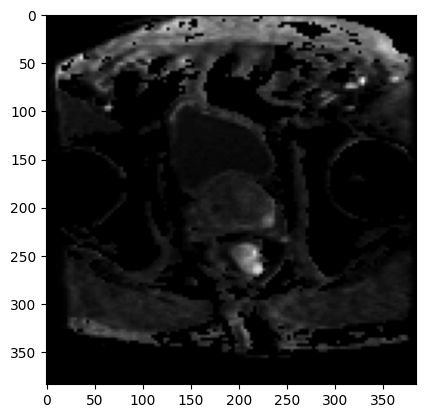

In [ ]:
img_name = '10008_1000008_hbv14_hbv.png'
img_folder = img_name.split('_')[0]
img_path = f"{img_folder}/{img_name}"

crop_data_utils.img_printer(os.path.join(input_path,img_path))

## Initial Data Check

In [ ]:
num_patient_folders = crop_data_utils.file_checker(input_path)

1479it [00:59, 24.91it/s]


Total number of patient folders: 1476
Total number of patient files: 109185
Total size of /content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prova2: 34.77 Gigabytes


In [ ]:
excluded_patients = ['10360', '10211', '10730', '10368', '10078', '10059', '10032', '11475', '11448', '11395', '11375', '11145', '10483', '10355', '10262', '10012',
                     '11257', '11163', '10635', '10339', '10688', '10241', '11338', '11253', '11167', '10650',
                     '10936', '10281', '10905', '10576', '10580', '10629', '10404', '10129', '10417', '10153', '10131', '11059', '11087', '10512', '11004', '11383',
                     '10193',
                     '10540', '10490', '10634', '11054', '10273', '10548']

num_excluded_patient_folders = len(excluded_patients)
print(num_excluded_patient_folders)

## Functions checks

In [ ]:
nifti_file = '10764_1000780.nii.gz'
rois,slices = crop_data_utils.get_crop_coordinates(os.path.join(wholegland_del_path,nifti_file), num_slices=5)

print("rois:", rois, '\n')
print("slices:",sorted(slices),'\n')
print("total positive slices:", len(slices))

rois: [[135, 253, 136, 254], [135, 251, 137, 253], [136, 254, 136, 254], [138, 250, 139, 251], [137, 255, 136, 254]] 

slices: [6, 7, 8, 9, 10] 

total positive slices: 5


## Crop Test

In [ ]:
# @title Backup
output_path = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prova3/'
counter = 0
processed_folders = 0
crop_shape=(64,64)
print('Begin Dataset Creation!',"\n")
# Loop over the patient folders
for patient_folder in os.listdir(input_path):
    print(f"\nProcessing folder: {patient_folder}","\n")
    if patient_folder in excluded_patients:
        continue
    counter += 1

    patient_path = os.path.join(input_path, patient_folder)
    if os.path.isdir(patient_path):
        # Create separate output directories for the cropped images in each patient folder
        output_path_t2w = os.path.join(output_path, patient_folder, 't2w')
        os.makedirs(output_path_t2w, exist_ok=True)
        output_path_adc = os.path.join(output_path, patient_folder, 'adc')
        os.makedirs(output_path_adc, exist_ok=True)
        output_path_hbv = os.path.join(output_path, patient_folder, 'hbv')
        os.makedirs(output_path_hbv, exist_ok=True)
        # Count the number of images in the patient folder
        image_count = len(glob.glob(os.path.join(patient_path, '*.png')))

        # Loop over the image files in the patient folder
        for image_path in glob.glob(os.path.join(patient_path, '*_t2w[0-9][0-9]_t2w.png'))\
                        + glob.glob(os.path.join(patient_path, '*_t2w[0-9][0-9]_adc.png'))\
                        + glob.glob(os.path.join(patient_path, '*_adc[0-9][0-9]_adc.png'))\
                        + glob.glob(os.path.join(patient_path, '*_hbv[0-9][0-9]_hbv.png')):
            patient_filename = image_path.split('/')[-1]
            print(f"\npatient_filename {patient_filename}")
            patient_id, _, image_type, slice_num = parse_image_filename(patient_filename, class_label=False)
            print(f"patient_id {patient_id}")
            print(f"study_id {study_id}")
            print(f"image_type {image_type}")
            print(f"slice_num {slice_num}\n")
            # ciclare per prendere il paziente specifico con il path
            patient_id_path = patient_id + '.nii.gz'
            patient_id_path_ann = patient_id + '.nii'
            wholegland_del_patient_path = os.path.join(wholegland_del_path, patient_id_path)
            annotation_patient_path = os.path.join(original_adc_ann_path, patient_id_path_ann)
            try:
                rois, slices = get_crop_coordinates(wholegland_del_patient_path,num_slices=5)
                # check if the slice is in the list of positive delineations
                if slice_num in slices:
                    # Get the coordinates for the current slice from the rois list
                    coordinates_list = rois[slices.index(slice_num)]

                    if re.search(r'_t2w\d{1,2}_t2w.png', image_path) or re.search(r'_t2w\d{1,2}_adc.png', image_path):
                        t2w_img = mpimg.imread(image_path)
                        t2w_img_crop = t2w_img[coordinates_list[0]:coordinates_list[1],\
                                               coordinates_list[2]:coordinates_list[3],:]
                        # resize the image to a fixed format
                        t2w_img_resized = resize(t2w_img_crop, crop_shape, preserve_range=True)
                        # save the cropped image to the output directory
                        img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension

                        if img_name.endswith("_adc"):
                            new_img_name = img_name.replace("_adc", "_t2w")
                        else:
                            new_img_name = img_name
                        # Save the cropped image with the new filename
                        output_img_path_t2w = os.path.join(output_path_t2w, new_img_name + '.png')
                        plt.imsave(output_img_path_t2w, t2w_img_resized)

                    elif re.search(r'_adc\d{1,2}_adc.png', image_path):
                        adc_img = mpimg.imread(image_path)
                        adc_img_crop = adc_img[coordinates_list[0]:coordinates_list[1],\
                                               coordinates_list[2]:coordinates_list[3],:]

                        # resize the image to a fixed format
                        adc_img_resized = resize(adc_img_crop, crop_shape, preserve_range=True)

                        # save the cropped image to the output directory
                        img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension
                        output_img_path_adc = os.path.join(output_path_adc, img_name + '.png')
                        plt.imsave(output_img_path_adc, adc_img_resized)

                    elif re.search(r'_hbv\d{1,2}_hbv.png', image_path):
                        hbv_img = mpimg.imread(image_path)
                        hbv_img_crop = hbv_img[coordinates_list[0]:coordinates_list[1],\
                                               coordinates_list[2]:coordinates_list[3],:]

                        # resize the image to a fixed format
                        hbv_img_resized = resize(hbv_img_crop, crop_shape, preserve_range=True)
                        # save the cropped image to the output directory
                        img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension
                        output_img_path_hbv = os.path.join(output_path_hbv, img_name + '.png')
                        plt.imsave(output_img_path_hbv, hbv_img_resized)

            except Exception as e:
                print(f"Error processing slice: {slice_num} in folder: {patient_folder}")
                print(f"Error message: {str(e)}")
                print(f"Problematic image path: {image_path}")
                continue
        # Increment the counter for processed patient output folders
        processed_folders += 1
        # Break the loop if the desired number of folders have been processed
        if processed_folders == 50:
            break
print("\t\t",'Number of folders processed...', counter,"\n")

In [ ]:
# @title funzione crop prova (backup)
def crop_dataset(input_path,output_root:str,crop_shape:tuple,num_slices:int, folder_breakpoint:int, excluded_patients:list):
    processed_folders = 1
    print('Begin Dataset Creation!',"\n")
    # Loop over the patient folders
    for patient_folder in os.listdir(input_path):
        if processed_folders % 5 == 0:
            print(f"\nprocessing folder number... {processed_folders}: {patient_folder}\n")
        else:
            print(f"\nProcessing folder: {patient_folder} \n")
        if patient_folder in excluded_patients:
            continue
        patient_path = os.path.join(input_path, patient_folder)
        if os.path.isdir(patient_path):
            # Create output directory fo each patient
            output_path = os.path.join(output_root, patient_folder)
            os.makedirs(output_path, exist_ok=True)
            # Loop over the image files in the patient folder
            for image_path in glob.glob(os.path.join(patient_path, '*.png')):
                patient_filename = image_path.split('/')[-1]
                patient_id, _, image_type, slice_num = parse_image_filename(patient_filename, class_label=False)
                print(f"\npatient_filename {patient_filename}")
                print(f"patient_id {patient_id}")
                print(f"study_id {study_id}")
                print(f"image_type {image_type}")
                print(f"slice_num {slice_num}\n")
                # ciclare per prendere il paziente specifico con il path
                wholegland_del_patient_path = os.path.join(wholegland_del_path, patient_id + '.nii.gz')
                try:
                    rois, slices = get_crop_coordinates(wholegland_del_patient_path,num_slices)
                    # check if the slice is in the list of positive delineations
                    if slice_num in slices:
                        # Get the coordinates for the current slice from the rois list
                        coordinates_list = rois[slices.index(slice_num)]
                        if re.search(r'_t2w\d{1,2}_t2w.png', image_path) or re.search(r'_t2w\d{1,2}_adc.png', image_path):
                            t2w_img = mpimg.imread(image_path)
                            t2w_img_crop = t2w_img[coordinates_list[0]:coordinates_list[1],\
                                                coordinates_list[2]:coordinates_list[3],:]
                            # resize the image to a fixed format
                            t2w_img_resized = resize(t2w_img_crop, crop_shape, preserve_range=True)
                            # save the cropped image to the output directory
                            img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension
                            if img_name.endswith("_adc"):
                                new_img_name = img_name.replace("_adc", "_t2w")
                            else:
                                new_img_name = img_name
                            # Save the cropped image with the new filename
                            output_img_path = os.path.join(output_path, new_img_name + '.png')
                            plt.imsave(output_img_path, t2w_img_resized)
                        elif re.search(r'_adc\d{1,2}_adc.png', image_path):
                            adc_img = mpimg.imread(image_path)
                            adc_img_crop = adc_img[coordinates_list[0]:coordinates_list[1],\
                                                coordinates_list[2]:coordinates_list[3],:]
                            # resize the image to a fixed format
                            adc_img_resized = resize(adc_img_crop, crop_shape, preserve_range=True)
                            # save the cropped image to the output directory
                            img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension
                            output_img_path = os.path.join(output_path, img_name + '.png')
                            plt.imsave(output_img_path, adc_img_resized)
                        elif re.search(r'_hbv\d{1,2}_hbv.png', image_path):
                            hbv_img = mpimg.imread(image_path)
                            hbv_img_crop = hbv_img[coordinates_list[0]:coordinates_list[1],\
                                                   coordinates_list[2]:coordinates_list[3],:]
                            # resize the image to a fixed format
                            hbv_img_resized = resize(hbv_img_crop, crop_shape, preserve_range=True)
                            # save the cropped image to the output directory
                            img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension
                            output_img_path = os.path.join(output_path, img_name + '.png')
                            plt.imsave(output_img_path, hbv_img_resized)
                except Exception as e:
                    print(f"Error processing slice: {slice_num} in folder: {patient_folder}")
                    print(f"Error message: {str(e)}")
                    #print(f"Problematic image path: {image_path}")
                    continue
        processed_folders += 1
        # Break the loop if the desired number of folders have been processed
        if folder_breakpoint:
            if processed_folders >= folder_breakpoint:
                print("\t\t",'Total folders processed...', processed_folders,"\n")
                break
    print("Dataset Creation Completed!")

In [ ]:
# @title
def crop_dataset_checkflag(input_path: str, output_root: str, crop_shape: tuple, num_slices: int,
                            folder_breakpoint: int, checkpoint_file: str, excluded_patients: list):
    processed_folders = 1
    print('Begin Dataset Creation!', "\n")
    # check checkpoint
    if checkpoint_file:
        if os.path.exists(checkpoint_file):
            with open(checkpoint_file, "r") as f:
                checkpoint_counter = int(f.read())
                print("\t", f"Checkpoint found! Resuming from folder number... {checkpoint_counter}")
        else:
            checkpoint_counter = 0
            with open(checkpoint_file, "w") as f:
                f.write(str(0))
                print("\t", f"Checkpoint not found. Creating new Checkpoint")
        # Loop over the patient folders
        for patient_folder in os.listdir(input_path):
            if processed_folders < checkpoint_counter:
                processed_folders += 1
                continue

            if patient_folder in excluded_patients:
                #processed_folders += 1
                continue

            if processed_folders % 1 == 0:
                print(f"\n\t\tProcessing folder number... {processed_folders}: {patient_folder}")
                with open(checkpoint_file,'w') as f:
                    checkpoint_counter = processed_folders
                    f.write(str(checkpoint_counter))

            patient_path = os.path.join(input_path, patient_folder)
            if os.path.isdir(patient_path):
                # Create output directory fo each patient
                output_path = os.path.join(output_root, patient_folder)
                os.makedirs(output_path, exist_ok=True)
                # Loop over the image files in the patient folder
                for image_path in glob.glob(os.path.join(patient_path, '*.png')):
                    patient_filename = image_path.split('/')[-1]
                    patient_id, _, image_type, slice_num = parse_image_filename(patient_filename, class_label=False)
                    # ciclare per prendere il paziente specifico con il path
                    wholegland_del_patient_path = os.path.join(wholegland_del_path, patient_id + '.nii.gz')
                    try:
                        rois, slices = get_crop_coordinates(wholegland_del_patient_path, num_slices)
                        # check if the slice is in the list of positive delineations
                        if slice_num in slices:
                            # Get the coordinates for the current slice from the rois list
                            coordinates_list = rois[slices.index(slice_num)]
                            if re.search(r'_t2w\d{1,2}_t2w.png', image_path) or re.search(
                                    r'_t2w\d{1,2}_adc.png', image_path):
                                t2w_img = mpimg.imread(image_path)
                                t2w_img_crop = t2w_img[coordinates_list[0]:coordinates_list[1], \
                                                       coordinates_list[2]:coordinates_list[3], :]
                                # resize the image to a fixed format
                                t2w_img_resized = resize(t2w_img_crop, crop_shape, preserve_range=True)
                                # save the cropped image to the output directory
                                img_name = os.path.splitext(os.path.basename(image_path))[0]
                                # extract the image name without extension
                                if img_name.endswith("_adc"):
                                    new_img_name = img_name.replace("_adc", "_t2w")
                                else:
                                    new_img_name = img_name
                                # Save the cropped image with the new filename
                                output_img_path = os.path.join(output_path, new_img_name + '.png')
                                plt.imsave(output_img_path, t2w_img_resized)

                            elif re.search(r'_adc\d{1,2}_adc.png', image_path):
                                adc_img = mpimg.imread(image_path)
                                adc_img_crop = adc_img[coordinates_list[0]:coordinates_list[1], \
                                                       coordinates_list[2]:coordinates_list[3], :]
                                # resize the image to a fixed format
                                adc_img_resized = resize(adc_img_crop, crop_shape, preserve_range=True)
                                # save the cropped image to the output directory
                                img_name = os.path.splitext(os.path.basename(image_path))[0]
                                # extract the image name without extension
                                output_img_path = os.path.join(output_path, img_name + '.png')
                                plt.imsave(output_img_path, adc_img_resized)

                            elif re.search(r'_hbv\d{1,2}_hbv.png', image_path):
                                hbv_img = mpimg.imread(image_path)
                                hbv_img_crop = hbv_img[coordinates_list[0]:coordinates_list[1], \
                                                       coordinates_list[2]:coordinates_list[3], :]
                                # resize the image to a fixed format
                                hbv_img_resized = resize(hbv_img_crop, crop_shape, preserve_range=True)
                                # save the cropped image to the output directory
                                img_name = os.path.splitext(os.path.basename(image_path))[0]
                                # extract the image name without extension
                                output_img_path = os.path.join(output_path, img_name + '.png')
                                plt.imsave(output_img_path, hbv_img_resized)

                    except Exception as e:
                        # print(f"Error processing slice: {slice_num} in folder: {patient_folder}")
                        # print(f"Error message: {str(e)}")
                        continue

                processed_folders += 1
                # Break the loop if the desired number of folders have been processed
                if folder_breakpoint:
                    if processed_folders >= folder_breakpoint:
                        print("\t\t", 'Total folders processed...', processed_folders, "\n")
                        break
        # Save the final checkpoint
        with open(checkpoint_file, 'w') as f:
            f.write(str(processed_folders))

        print("Dataset Creation Completed!")

    else:
        crop_dataset(input_path, output_root, crop_shape, num_slices, folder_breakpoint, excluded_patients)

In [ ]:
output_root = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prova'

crop_dataset_utils.crop_dataset(input_path,output_root,crop_shape=(64,64),num_slices=5,
                                folder_breakpoint=10, wholegland_del_path = wholegland_del_path,
                                excluded_patients=excluded_patients)

In [ ]:
# Check the newly crated dataset
output_path = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prova_checkpoint'

crop_dataset_utils.file_checker(output_path)

In [ ]:
output_path = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prova/'

crop_dataset_utils.check_anomalies(output_path, 0)


Total number of patient directories: 49
Total number of patient directories with anomalies: 0
Total number of anomalies: 0


## Complete Crop

In [ ]:
# @title backup
output_path = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prostate_centered/'
counter = 0
checkpoint_counter = 0
checkpoint_interval = 10
crop_shape=(64,64)
checkpoint_file = "/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/checkpoints/checkpoint.txt"

print('Begin Dataset Creation!',"\n")
# Check if a checkpoint file exists
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "r") as f:
        checkpoint_counter = int(f.read())
        print("\t", f"Checkpoint found! Resuming from folder... {checkpoint_counter}")
else:
    with open(checkpoint_file, "w") as f:
        f.write("0")
        checkpoint_counter = 0
        print("\t", f"Checkpoint not found. Creating new Checkpoint")

# Loop over the patient folders
for patient_folder in os.listdir(input_path):
    #print(f"Processing folder: {patient_folder}")
    if patient_folder in excluded_patients:
        continue
    counter += 1

    if counter <= checkpoint_counter:
        continue
    patient_path = os.path.join(input_path, patient_folder)

    if counter % checkpoint_interval == 0:
        save_checkpoint(counter, checkpoint_file=checkpoint_file)
        print("\t\t",'Number of folders processed...', counter, flush=True)

    if os.path.isdir(patient_path):
        # Create separate output directories for the cropped T2W and ADC images in each patient folder
        output_path_t2w = os.path.join(output_path, patient_folder, 't2w')
        output_path_adc = os.path.join(output_path, patient_folder, 'adc')
        output_path_hbv = os.path.join(output_path, patient_folder, 'hbv')

        os.makedirs(output_path_t2w, exist_ok=True)
        os.makedirs(output_path_adc, exist_ok=True)
        os.makedirs(output_path_hbv, exist_ok=True)
        # Count the number of images in the patient folder
        image_count = len(glob.glob(os.path.join(patient_path, '*.png')))

        # Loop over the image files in the patient folder
        for image_path in glob.glob(os.path.join(patient_path, '*_t2w[0-9][0-9]_t2w.png'))\
                        + glob.glob(os.path.join(patient_path, '*_t2w[0-9][0-9]_adc.png'))\
                        + glob.glob(os.path.join(patient_path, '*_adc[0-9][0-9]_adc.png'))\
                        + glob.glob(os.path.join(patient_path, '*_hbv[0-9][0-9]_hbv.png')):
            patient_filename = image_path.split('/')[-1]
            patient_id, study_id, image_type, slice_num =\
            parse_image_filename(patient_filename)
            # ciclare per prendere il paziente specifico con il path
            # extract the slice number from the image file name
            slice_num = int(os.path.splitext(os.path.basename(image_path))[0].split("_")[-2][3:])

            # ciclare per prendere il paziente specifico con il path
            patient_id_path = patient_id + '.nii.gz'
            wholegland_del_patient_path = os.path.join(wholegland_del_path, patient_id_path)

            try:
                rois, slices = get_crop_coordinates(wholegland_del_patient_path,num_slices=5) # num slices

                # check if the slice is in the list of positive delineations
                if slice_num in slices:
                    # Get the coordinates for the current slice from the rois list
                    coordinates_list = rois[slices.index(slice_num)]

                    if re.search(r'_t2w\d{1,2}_t2w.png', image_path) or re.search(r'_t2w\d{1,2}_adc.png', image_path):
                        t2w_img = mpimg.imread(image_path)
                        t2w_img_crop = t2w_img[coordinates_list[0]:coordinates_list[1],\
                                               coordinates_list[2]:coordinates_list[3],:]

                        # resize the image to a fixed format
                        t2w_img_resized = resize(t2w_img_crop, crop_shape, preserve_range=True)
                        # save the cropped image to the output directory
                        img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension

                        if img_name.endswith("_adc"):
                            new_img_name = img_name.replace("_adc", "_t2w")
                        else:
                            new_img_name = img_name
                        # Save the cropped image with the new filename
                        output_img_path_t2w = os.path.join(output_path_t2w, new_img_name + '.png')
                        plt.imsave(output_img_path_t2w, t2w_img_resized)

                    elif re.search(r'_adc\d{1,2}_adc.png', image_path): re.search(r'_adc\d{1,2}_adc.png', image_path)
                        adc_img = mpimg.imread(image_path)
                        adc_img_crop = adc_img[coordinates_list[0]:coordinates_list[1],\
                                               coordinates_list[2]:coordinates_list[3],:]

                        # resize the image to a fixed format
                        adc_img_resized = resize(adc_img_crop, crop_shape, preserve_range=True)

                        # save the cropped image to the output directory
                        img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension
                        output_img_path_adc = os.path.join(output_path_adc, img_name + '.png')
                        plt.imsave(output_img_path_adc, adc_img_resized)

                    elif re.search(r'_hbv\d{1,2}_hbv.png', image_path):
                        hbv_img = mpimg.imread(image_path)
                        hbv_img_crop = hbv_img[coordinates_list[0]:coordinates_list[1],\
                                               coordinates_list[2]:coordinates_list[3],:]

                        # resize the image to a fixed format
                        hbv_img_resized = resize(hbv_img_crop, crop_shape, preserve_range=True)
                        # save the cropped image to the output directory
                        img_name = os.path.splitext(os.path.basename(image_path))[0]  # extract the image name without extension
                        output_img_path_hbv = os.path.join(output_path_hbv, img_name + '.png')
                        plt.imsave(output_img_path_hbv, hbv_img_resized)

            except Exception as e:
                print(f"Error processing slice: {slice_num} in folder: {patient_folder}")
                print(f"Error message: {str(e)}")
                print(f"Problematic image path: {image_path}")
                continue

# Save the final checkpoint
save_checkpoint(counter, checkpoint_file)
print("\t\t",'Number of folders processed...', counter,"\n")

# Check if dataset creation is complete
if counter >= len(os.listdir(input_path))-len(excluded_patients):
    print("Dataset Creation Completed!")

In [ ]:
output_root = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prostate_centered'
checkpoint_file = "/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/checkpoints/checkpoint.txt"
folder_breakpoint = num_patient_folders - num_excluded_patient_folders

crop_data_utils.crop_dataset_checkflag(input_path,output_root,crop_shape=(64,64),
                                        num_slices=5,folder_breakpoint=folder_breakpoint,
                                        wholegland_del_path = wholegland_del_path,
                                        checkpoint_file=checkpoint_file,
                                        excluded_patients=excluded_patients)

## Additional checks

In [ ]:
# Check the newly crated dataset
crop_data_utils.file_checker(output_path)

1428it [00:11, 122.58it/s]


Total number of patient folders: 1427
Total number of patient files: 21222
Total size of /content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prova2: 0.10 Gigabytes


In [ ]:
crop_data_utils.check_anomalies(output_path, 15)


Total number of patient directories: 1427
Total number of patient directories with anomalies: 0
Total number of anomalies: 0
